# Behavioural cloning project

In [1]:
# Configure matlab to show graphics in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Change to 'data' when training on a GPU
PATH_TO_DATA = 'data/sample/'

In [3]:
# Shape of the image
input_shape = (66, 200, 3)

In [4]:
def img_folder(data_folder):
    return '{}/IMG'.format(data_folder)

def path_driving_log(data_folder):
    return '{}/driving_log.csv'.format(data_folder)

In [5]:
datasets = ['train', 'test', 'valid']

In [6]:
def get_driving_log_dataframe(data_folder):
    driving_log_df = pd.read_csv(path_driving_log(data_folder))
    return driving_log_df

In [7]:
driving_log_df = get_driving_log_dataframe(PATH_TO_DATA)

In [8]:
zero_approximation = 10e-4

In [9]:
num_positive_steerings = len(driving_log_df[driving_log_df['steering'] > zero_approximation])
num_negative_steerings = len(driving_log_df[driving_log_df['steering'] < -zero_approximation])
num_neutral_steerings = len(driving_log_df[abs(driving_log_df['steering']) <= zero_approximation])

print('Positive: {}'.format(num_positive_steerings))
print('Negative: {}'.format(num_negative_steerings))
print('Neutral: {}'.format(num_neutral_steerings))

Positive: 10
Negative: 5
Neutral: 4


In [10]:
positive_steering_weight = 10
negative_steering_weight = num_positive_steerings * 10/ num_negative_steerings
neutral_steering_weight = num_positive_steerings * 10 / num_neutral_steerings

In [11]:
path_to_folders = dict(zip(datasets, map(lambda folder: '{0}/{1}'.format(PATH_TO_DATA, folder), datasets)))

In [12]:
import cv2

In [13]:
from scipy.ndimage import imread
from os import listdir
from sklearn.utils import shuffle

from PIL import Image

import math


def image_label_generator(data_folder, batch_size=64):
    driving_log_df = get_driving_log_dataframe(data_folder)
    number_of_examples = len(driving_log_df)
    image_columns = ['center', 'left', 'right']
    
    X_train = []
    y_train = []
    weights = []
    index_in_batch = 0
    batch_number = 0
    
    angle_offset = 0.2
    
    while True:
        for image_column in image_columns:
            image_series = driving_log_df[image_column]
            steering_series = driving_log_df['steering']
            for offset in range(0, number_of_examples, batch_size):
                X_train = []
                y_train = []
                weights = []

                end_of_batch = min(number_of_examples, offset + batch_size)

                for j in range(offset, end_of_batch):
                    image_filename = image_series[j].lstrip().rstrip()
                    
                    image = Image.open('{0}/{1}'.format(data_folder, image_filename))
                    image = image.convert('YCbCr')
                    image_np = np.asarray(image.resize((200, 66)))
                    label = steering_series[j]
                    
                    weights.append(1)
                    
                    if image_column == 'left':
                        delta_steering = label - angle_offset
                    if image_column == 'right':
                        delta_steering = label + angle_offset
                    else:
                        delta_steering = 0
                    
                    X_train.append(image_np)
                    y_train.append(label + delta_steering)
                    
                    flipped_image = cv2.flip(image_np, 1)
                    flipped_label = -label
                    
                    X_train.append(flipped_image)
                    y_train.append(flipped_label)
                    weights.append(1)
                    
                    X_train, y_train, weights = shuffle(X_train, y_train, weights)

                yield np.array(X_train), np.array(y_train), np.array(weights)

In [14]:
X, y, w = next(image_label_generator(PATH_TO_DATA))

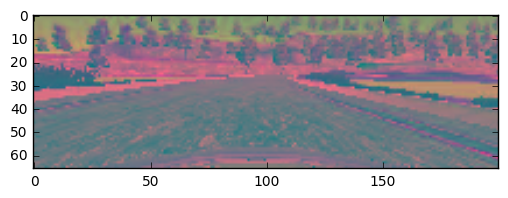

In [17]:
plt.imshow(X[0])

In [19]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Lambda

Using TensorFlow backend.


In [34]:
model = Sequential()

In [35]:
model.add(Lambda(lambda x: x/255.0,
            input_shape=input_shape))
model.add(Convolution2D(24, 
                        5, 5,
                       subsample=(2, 2),
                       init='he_normal'))
model.add(Convolution2D(36, 
                        5, 5,
                       subsample=(2, 2),
                       init='he_normal'))
model.add(Convolution2D(48, 
                        5, 5,
                       subsample=(2, 2),
                       init='he_normal'))
model.add(Convolution2D(64,
                       3, 3,
                       init='he_normal'))
model.add(Convolution2D(64,
                       3, 3,
                       init='he_normal'))
model.add(Flatten())
model.add(Dense(100, activation='relu', init='he_normal'))
model.add(Dense(50, activation='relu', init='he_normal'))
model.add(Dense(10, activation='relu', init='he_normal'))
model.add(Dense(1, activation='linear', init='he_normal'))

In [36]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 66, 200, 3)    0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 14, 47, 36)    21636       convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 5, 22, 48)     43248       convolution2d_7[0][0]            
___________________________________________________________________________________________

In [37]:
from keras.callbacks import ModelCheckpoint
filepath="weights-improvement-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath)
callbacks_list = [checkpoint]

In [38]:
from keras.optimizers import Adam
adam = Adam(lr=10e-4)

In [39]:
model.compile(optimizer=adam, 
              loss='mse',
             metrics=['mean_squared_error'])

In [40]:
image_generator = image_label_generator(PATH_TO_DATA)
samples = len(get_driving_log_dataframe(PATH_TO_DATA))

In [41]:
image_generator = image_label_generator(PATH_TO_DATA)
samples = len(get_driving_log_dataframe(PATH_TO_DATA)) * 3 * 2
model.fit_generator(image_generator, 
                    samples_per_epoch=samples, 
                    nb_epoch=5,
                   callbacks=callbacks_list)

Epoch 1/5
114/114 [==============================] - 2s - loss: 22.2137 - mean_squared_error: 22.2137     
Epoch 2/5
114/114 [==============================] - 1s - loss: 1.1774 - mean_squared_error: 1.1774     
Epoch 3/5
114/114 [==============================] - 1s - loss: 0.0550 - mean_squared_error: 0.0550     
Epoch 4/5
114/114 [==============================] - 1s - loss: 0.0223 - mean_squared_error: 0.0223     

In [42]:
X_val, y_val, w = next(image_label_generator(PATH_TO_DATA))

In [43]:
model.predict(X_val)

array([[-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594],
       [-0.00723594]], dtype=float32)

In [44]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [45]:
y_val

array([-0.1670138 ,  0.07132844,  0.1670138 ,  0.1670138 , -0.1670138 ,
       -0.07132844, -0.0617599 ,  0.05975719, -0.04076847,  0.0617599 ,
        0.01391724, -0.05975719, -0.        ,  0.1670138 , -0.        ,
       -0.07132844, -0.0617599 , -0.1167233 , -0.        , -0.0617599 ,
        0.09773462,  0.05975719,  0.        , -0.05975719, -0.07132844,
        0.07132844,  0.        ,  0.        , -0.01391724, -0.09773462,
        0.        ,  0.07132844,  0.0617599 , -0.1670138 ,  0.0617599 ,
        0.04076847, -0.        ,  0.1167233 ])

In [24]:
from keras.models import model_from_json

with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [26]:
loaded_model.compile(optimizer=adam, 
              loss='mse',
             metrics=['mean_squared_error'])

image_generator = image_label_generator(PATH_TO_DATA)
samples = len(get_driving_log_dataframe(PATH_TO_DATA))

loaded_model.fit_generator(image_generator, 
                    samples_per_epoch=samples, 
                    nb_epoch=10,
                   callbacks=callbacks_list)

Epoch 1/10
14816/14816 [==============================] - 50s - loss: 0.3507 - mean_squared_error: 0.0380    
Epoch 2/10
14816/14816 [==============================] - 48s - loss: 0.2957 - mean_squared_error: 0.0293    
Epoch 3/10
14816/14816 [==============================] - 48s - loss: 0.2632 - mean_squared_error: 0.0268    
Epoch 4/10
14816/14816 [==============================] - 48s - loss: 0.2357 - mean_squared_error: 0.0250    
Epoch 5/10
14816/14816 [==============================] - 48s - loss: 0.2257 - mean_squared_error: 0.0248    
Epoch 6/10
14816/14816 [==============================] - 48s - loss: 0.2068 - mean_squared_error: 0.0233    
Epoch 7/10
14816/14816 [==============================] - 48s - loss: 0.2041 - mean_squared_error: 0.0234    
Epoch 8/10
14816/14816 [==============================] - 48s - loss: 0.2040 - mean_squared_error: 0.0233    
Epoch 9/10
14816/14816 [==============================] - 48s - loss: 0.1937 - mean_squared_error: 0.0221    
Epoch 10/1